In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from general.pulses import blackman_pulse, square_pulse

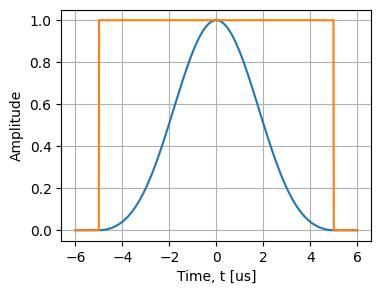

In [2]:
t = np.linspace(-6, 6, 1000)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(t, blackman_pulse(t+t_width/2, t_width))
ax.plot(t, square_pulse(t+t_width/2, t_width))
ax.grid(True)
ax.set(xlabel="Time, t [us]", ylabel="Amplitude")

plt.show()

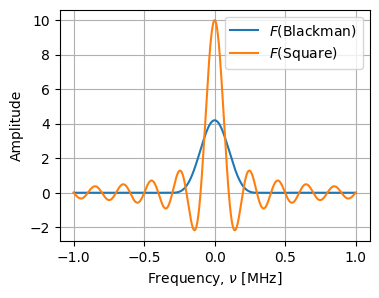

In [3]:
from general.pulses import blackman_fourier

nu = np.linspace(-1, 1, 1000)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu, blackman_fourier(nu, t_width), label=r'$F$(Blackman)')
ax.plot(nu, t_width*np.sinc(t_width*nu), label=r'$F$(Square)')
ax.grid(True)
ax.set(xlabel=r"Frequency, $\nu$ [MHz]", ylabel="Amplitude")
ax.legend(loc="upper right")

plt.show()

Average SquareFourier^2 at large x compared to BlackmanFourier^2 is 4.217287374647689e-64


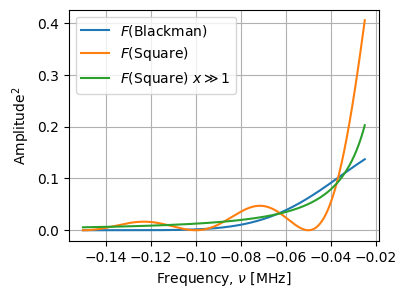

In [4]:
from general.pulses import blackman_fourier

nu_test = -0.15
nu = np.linspace(nu_test, -0.025, 1000)
t_width = 20

def large_x_sinc(x):
    return 1/np.sqrt(2)* np.piecewise(x, [x==0, x!=0], [1, lambda x: 1/(np.pi * x)])

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu, (blackman_fourier(nu, t_width)/t_width)**2, label=r'$F$(Blackman)')
ax.plot(nu, np.sinc(t_width*nu)**2, label=r'$F$(Square)')
ax.plot(nu, large_x_sinc(t_width*nu)**2, label=r'$F$(Square) $x\gg1$') 
ax.grid(True)
ax.set(xlabel=r"Frequency, $\nu$ [MHz]", ylabel=r"Amplitude$^2$")
ax.legend(loc="upper left")

ratio = (blackman_fourier(nu_test, t_width)/t_width)**2/large_x_sinc(t_width*nu_test)**2

print(f"Average SquareFourier^2 at large x compared to BlackmanFourier^2 is {ratio}")

plt.show()

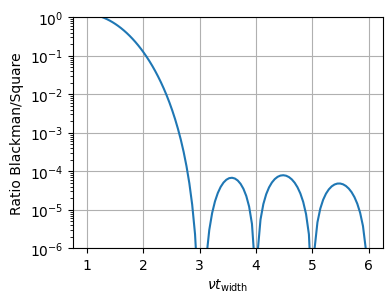

In [5]:
fig, ax = plt.subplots(figsize=(4,3))

detuning = np.linspace(1, 6, 100)

def ratio_func(det):
    return (blackman_fourier(det, 1))**2/large_x_sinc(det)**2

ax.plot(detuning, ratio_func(detuning))
ax.grid(True)
ax.set(xlabel=r"$\nu t_\mathrm{width}$", ylabel=r"Ratio Blackman/Square",
       yscale='log', ylim=(10e-7, 1))

plt.show()

## Convolution of Blackman on -3/2s tail

In [8]:
from scipy.signal import fftconvolve, convolve

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# --- Parameters ---
# Time widths of Blackman window.
t_list = np.array([2.5, 5, 10, 20, 40, 80, 160, 320, 600, 1.2e3, 2.4e3])   

nu_s = 0.150            # Frequency shift of Blackman window.
gamma = 0.005            # Lorentzian HWHM (broad).
nu0 = 0.0              # Lorentzian center frequency.
x_i = gamma             # Lorentzian to -3/2s tail roll-over.
U_trap = 0.2            # Trap depth

# --- Frequency grid ---
samples = 5e4
nu = np.linspace(-2, 2, int(samples))
ind_nu_s = np.argmin(np.abs(nu - nu_s))  # Find index of closest value to nu_s.
ind_x_i = np.argmin(np.abs(nu - x_i))  # Find index of closest value to x_i.

# --- Shifted Blackman FT ---
B = lambda t_width: (blackman_fourier(nu - nu_s, t_width)/t_width)**2

# --- Response ---
def lorentzian(nu):
    return 1 / (1 + ((nu - nu0) / gamma) ** 2)

L = lorentzian(nu)

def spectrum(nu, x_i):
    cond_list = [nu <= x_i, nu > 0]
    crossover_y = lorentzian(x_i) * x_i**(3/2)
    func_list = [lorentzian, lambda x: crossover_y*x**(-3/2)]
    return np.piecewise(nu, cond_list, func_list)

S = spectrum(nu, x_i=x_i)

# --- Convolution (normalized) ---
C_fft = np.array([fftconvolve(S, B(t), mode='same') for t in t_list])
C_fft /= np.max(C_fft[0])  # Normalize arbitrarily for clarity.

C = np.array([convolve(S, B(t), mode='same', method='direct') for t in t_list])
C /= np.max(C[0])  # Normalize arbitrarily for clarity.

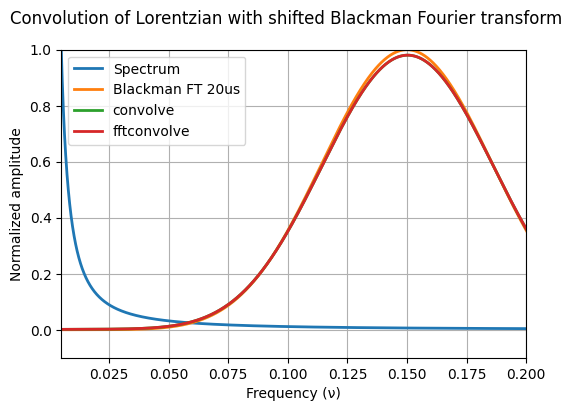

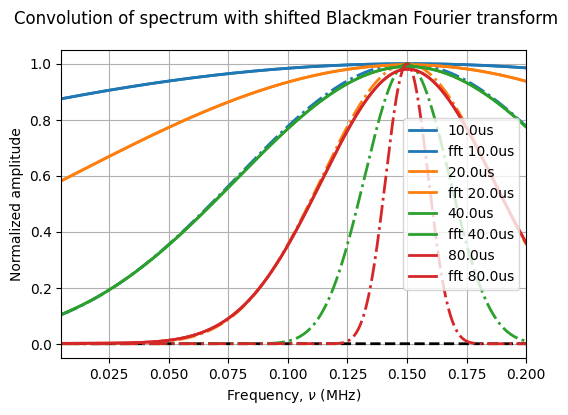

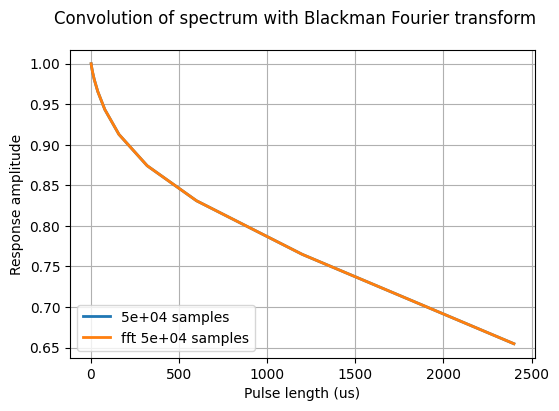

In [9]:
# --- Plot results ---
fig, ax = plt.subplots(figsize=(6, 4))
# plt.plot(nu, L / np.max(L), label="Lorentzian", color="tab:blue", lw=2)
ax.plot(nu, S / np.max(S[ind_x_i]), label="Spectrum", color="tab:blue", lw=2)
ax.plot(nu, B(20) / np.max(B(20)), label="Blackman FT 20us", color="tab:orange", lw=2)
ax.plot(nu, C[3], label="convolve", color="tab:green", lw=2)
ax.plot(nu, C_fft[3], label="fftconvolve", color="tab:red", lw=2)
fig.suptitle("Convolution of Lorentzian with shifted Blackman Fourier transform")
ax.set(xlabel="Frequency (ν)", ylabel="Normalized amplitude", xlim=(x_i, U_trap),
       ylim=(-0.1, 1))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(nu, S / np.max(S), "--k", lw=2)
for i, t in enumerate(t_list[2:6]):
    color = colors[i]
    plt.plot(nu, C[i], '-', label=f"{t}us", lw=2, color=color)
    plt.plot(nu, C_fft[i], '-', label=f"fft {t}us", lw=2, color=color)
    plt.plot(nu, B(t) / np.max(B(t)), '-.', lw=2, color=colors[i])
fig.suptitle("Convolution of spectrum with shifted Blackman Fourier transform")
ax.set(xlabel=r"Frequency, $\nu$ (MHz)", ylabel="Normalized amplitude", xlim=(x_i, U_trap))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(t_list, [Ci[ind_nu_s] for Ci in C], lw=2, label=f'{samples:.0e} samples')
ax.plot(t_list, [Ci[ind_nu_s] for Ci in C_fft], lw=2, label=f'fft {samples:.0e} samples')
# ax.plot(t_list, lin_func(t_list), '--')
# ax.plot(t_list, v_low_samples_C, lw=2, label='5e3 samples')
# # ax.plot(t_list, low_samples_C, lw=2, label='5e4 samples')
# ax.plot(t_list, med_samples_C, lw=2, label='5e5 samples')
# ax.plot(t_list, many_samples_C, lw=2, label='5e6 samples')
ax.legend(loc='lower left')

fig.suptitle("Convolution of spectrum with Blackman Fourier transform")
ax.set(xlabel="Pulse length (us)", ylabel="Response amplitude")
ax.grid(True)
plt.show()

### Try various widths and samples, naive convolution calculation

In [17]:
# --- Parameters ---
nu_s = 0.150            # Frequency shift of Blackman window.
gamma = 0.005            # Lorentzian HWHM (broad).
nu0 = 0.0              # Lorentzian center frequency.
x_i = gamma             # Lorentzian to -3/2s tail roll-over.
U_trap = 0.2            # Trap depth


def lorentzian(nu):
    return 1 / (1 + ((nu - nu0) / gamma) ** 2)


def spectrum(nu, x_i):
    cond_list = [nu <= x_i, nu > 0]
    crossover_y = lorentzian(x_i) * x_i**(3/2)
    func_list = [lorentzian, lambda x: crossover_y*x**(-3/2)]
    return np.piecewise(nu, cond_list, func_list)


# --- Frequency grid ---
samples_list = np.array([1e2, 1e3, 1e4, 1e5, 1e6])

# Time widths of Blackman window.
t_list = np.array([2.5, 2.5e1, 2.5e2, 2.5e3])   

attenuations = np.zeros_like(samples_list)
attenuation_ffts = np.zeros_like(samples_list)

Cs = []
C_ffts = []

for i, samples in enumerate(samples_list):
    nu = np.linspace(-2, 2, int(samples))
    ind_nu_s = np.argmin(np.abs(nu - nu_s))  # Find index of closest value to nu_s.
    ind_x_i = np.argmin(np.abs(nu - x_i))  # Find index of closest value to x_i.

    # --- Shifted Blackman FT ---
    B = lambda t_width: (blackman_fourier(nu - nu_s, t_width)/t_width)**2

    # --- Response ---
    L = lorentzian(nu)
    S = spectrum(nu, x_i=x_i)

    # --- Convolution (normalized) ---
    C_fft = np.array([fftconvolve(S, B(t), mode='same') for t in t_list])
    C_fft /= np.max(C_fft[0])  # Normalize arbitrarily for clarity.

    C = np.array([convolve(S, B(t), mode='same', method='direct') for t in t_list])
    C /= np.max(C[0])  # Normalize arbitrarily for clarity.

    C_at_nu_s = [Ci[ind_nu_s] for Ci in C]
    C_fft_at_nu_s = [Ci[ind_nu_s] for Ci in C_fft]

    Cs.append(C_at_nu_s)
    C_ffts.append(C_fft_at_nu_s)
    attenuations[i] = C_at_nu_s[-1]/C_at_nu_s[0]
    attenuation_ffts[i] = C_fft_at_nu_s[-1]/C_fft_at_nu_s[0]

C:\Users\colin\AppData\Local\Temp\ipykernel_4132\117566372.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


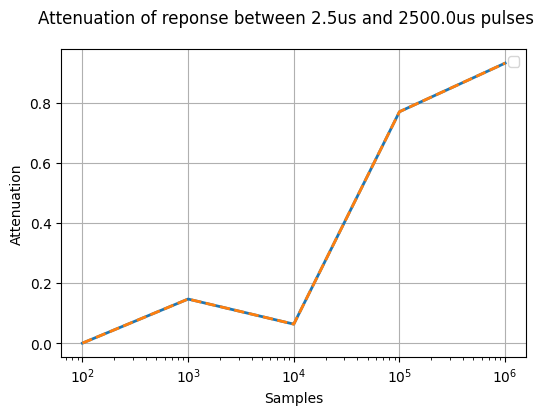

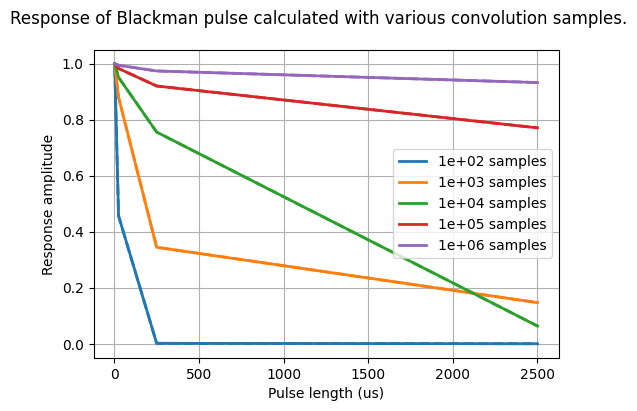

In [22]:
# --- Plot results ---
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(samples_list, attenuations, color="tab:blue", lw=2)
ax.plot(samples_list, attenuations, '--', color="tab:orange", lw=2)
fig.suptitle(f"Attenuation of reponse between {t_list[0]}us and {t_list[-1]}us pulses")
ax.set(xlabel="Samples", ylabel="Attenuation", xscale='log')
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
for i, samples in enumerate(samples_list):
    color = colors[i]
    ax.plot(t_list, Cs[i], lw=2, label=f'{samples:.0e} samples', color=color)
    ax.plot(t_list, C_ffts[i], '--', lw=2, color=color)

ax.legend(loc='center right')
fig.suptitle("Response of Blackman pulse calculated with various convolution samples.")
ax.set(xlabel="Pulse length (us)", ylabel="Response amplitude")
ax.grid(True)
plt.show()

### Just compute single frequency response from convolution

For 20us pulse, norm is 0.015.
1.1827891066214686
For 40us pulse, norm is 0.008.
1.0830775615388446
For 60us pulse, norm is 0.005.
1.0682345364342385
For 120us pulse, norm is 0.003.
1.0597114486360382
For 200us pulse, norm is 0.002.
1.0579279316816517
For 2000us pulse, norm is 0.000.
1.0569398811467343
For 20000us pulse, norm is 0.000.
1.0569300190864708


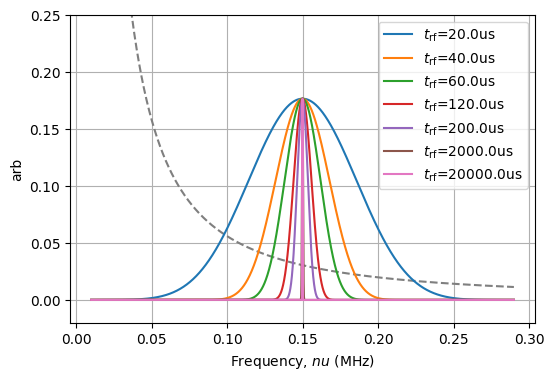

In [77]:
# --- Parameters ---
nu_s = 0.150            # Frequency shift of Blackman window.
gamma = 0.005            # Lorentzian HWHM (broad).
nu0 = 0.0              # Lorentzian center frequency.
x_i = gamma             # Lorentzian to -3/2s tail roll-over.
U_trap = 0.2            # Trap depth


def lorentzian(nu):
    return 1 / (1 + ((nu - nu0) / gamma) ** 2)


def spectrum(nu, x_i):
    cond_list = [nu <= x_i, nu > 0]
    crossover_y = lorentzian(x_i) * x_i**(3/2)
    func_list = [lorentzian, lambda x: crossover_y*x**(-3/2)]
    return np.piecewise(nu, cond_list, func_list)


def blackman_ft(nu, t_width):
    return (blackman_fourier(nu, t_width)/t_width)**2


samples = 1e5
nu_min = 0.01
nu_max = 2*nu_s - nu_min
nu = np.linspace(nu_min, nu_max, int(samples))

t_widths = np.array([20., 40., 60., 120., 200., 2000., 20000.])  # us
M = np.zeros_like(t_widths)

fig, ax = plt.subplots(figsize=(6,4))
ax.set(xlabel=r"Frequency, $nu$ (MHz)", ylabel="arb", ylim=(-0.02, 0.25))

S = spectrum(nu, x_i=x_i)
S_norm = np.trapezoid(S, nu)
ax.plot(nu, S*10, '--', color=colors[len(t_widths)])
S /= S_norm

for i, t_width in enumerate(t_widths):
    color=colors[i]

    B_pulse = blackman_ft(nu - nu_s, t_width)
    ax.plot(nu, B_pulse, '-', color=color, label=r'$t_\mathrm{rf}$='+f'{t_width}us')

    B_norm = np.trapezoid(B_pulse, nu)
    B_pulse /= B_norm
    print(f"For {t_width:.0f}us pulse, norm is {B_norm:.3f}.")

    B = blackman_ft(nu_s - nu, t_width)/B_norm
    M[i] = np.trapezoid(S * B, nu)

    print(np.sum(S*B*(nu[1]-nu[0])))


ax.legend()
ax.grid(True)
plt.show()

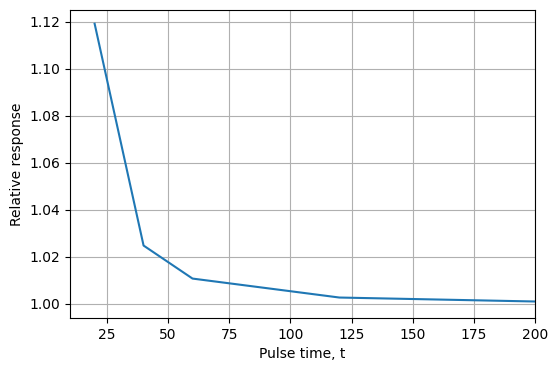

In [72]:
M_true = 1.05693002 # Taken from 20e3 us pulse

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t_widths, M/M_true)
ax.set(xlabel="Pulse time, t", ylabel="Relative response")
ax.set(xlim=(10, 200))
ax.grid(True)

plt.show()

In [76]:
15/8 * (50/150)**2
max(B*B_norm)
0.17626117641547914/np.e

0.06484286307994748

## Plot for figures

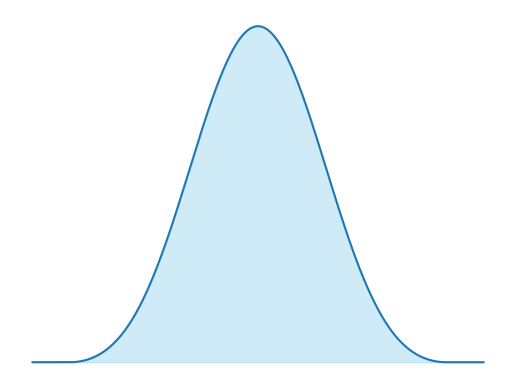

In [4]:
t = np.linspace(-0.1, 1.1, 1000)
t_width = 1

y = blackman_pulse(t, t_width)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.fill_between(t, y, color='skyblue', alpha=0.4) 
# plt.plot(t, square_pulse(t, t_width))
ax.set(xlabel="Time, t", ylabel="Amplitude")

ax.axis('off')

plt.show()

# fig.savefig("outputs/blackman_envelope_with_fill.pdf")

## Understanding a_1 coefficient sign

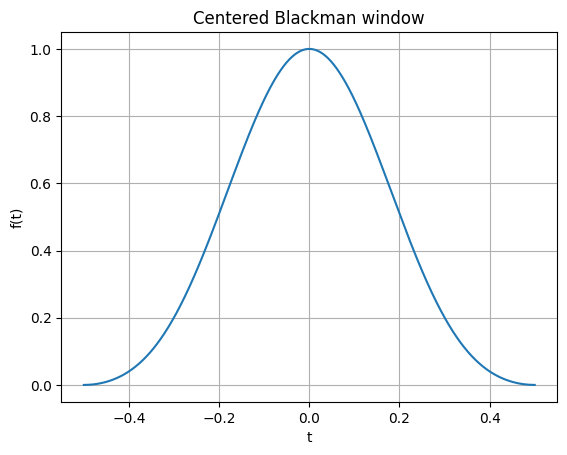

In [5]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.16
a0 = (1 - alpha)/2
a1 = 0.5
a2 = alpha/2

t_w = 1.0
t = np.linspace(-t_w/2, t_w/2, 1000)
f = a0 + a1*np.cos(2*np.pi*t/t_w) + a2*np.cos(4*np.pi*t/t_w)

plt.plot(t, f)
plt.title("Centered Blackman window")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.show()
